## Preprocessing

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from datetime import timedelta
from itertools import product
from collections import Counter, defaultdict

# RINGITY IMPORTS
import ringity as rng
import ringity.utils.plotting as rplotting
import ringity.networks.networkmodel.distributions as rdist
import ringity.networks.networkmodel.transformations as rtrafo

from ringity.utils import exceptions as rexceptions

rplotting.set_theme()
DIRNAME_DATA = Path.cwd().parent / 'data'
DIRNAME_PLOTS = DIRNAME_DATA / 'plots'

In [2]:
t1 = time.time()

### Set model parameters

In [3]:
CONFIGURATION = {
    'default' : {
        'c' : 1,
        'r' : 0.1,
        'beta' : 1,
    }}

CONFIGURATION['longer_response'] = CONFIGURATION['default'].copy()
CONFIGURATION['longer_response']['r'] = 0.2

CONFIGURATION['stronger_coupling'] = CONFIGURATION['default'].copy()
CONFIGURATION['stronger_coupling']['c'] = 0.5

CONFIGURATION['shorter_delay'] = CONFIGURATION['default'].copy()
CONFIGURATION['shorter_delay']['beta'] = 0.75

In [4]:
N = 2**9

N_ENSEMBLE = 2**4
N_ARG_POINTS = 2**4


# N = 2**7

# N_ENSEMBLE = 2**2
# N_ARG_POINTS = 2**3

### Auciliary functions

In [5]:
def draw_interaction_function(builder):
    r0 = CONFIGURATION['default']['r']
    c0 = CONFIGURATION['default']['c']
    
    intfunc_fig, ax = plt.subplots(figsize = (8,5))
    
    c = builder.coupling
    r = builder.response
    
    x = np.linspace(0, np.pi, 100)
    y = c*(1-x/(2*np.pi*r)).clip(0)
    y_default = c0*(1-x/(2*np.pi*r0)).clip(0)

    ax.plot(x, y_default, 'gray', alpha = 0.25, linewidth = 5)
    ax.plot(x, y, linewidth = 5)

    plt.xticks([1, 2, 2*np.pi*r, np.pi], [r'$1$', r'$2$', r'$2\pi r$', r'$\pi$'])
    plt.yticks([0, 0.25, 0.5, 1, c], [r'$0$', r'$0.25$', r'$0.5$', r'$1$', r'$c$'])

    ax.set_ylim(-0.025, max(0.5, c) + 0.025)
    
    return intfunc_fig


def draw_network_visualiztion(builder, N = 2**9, layout = 'both'):
    
    G, pos = rng.network_model(
                                N = N,
                                return_positions = True,
                                c = builder.coupling,
                                r = builder.response,
                                rho = builder.density,
                                beta = builder.delay)
    
    circ_layout = {n:(np.cos(t), np.sin(t)) for n,t in enumerate(pos)}
    spring_layout = nx.spring_layout(G)
    
    if layout == 'both':
        netviz_fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))
        ax1.set_xlim(-1.175,1.175)
        ax1.set_ylim(-1.175,1.175)

        ax2.set_xlim(-1.175,1.175)
        ax2.set_ylim(-1.175,1.175)
    else:
        netviz_fig, ax = plt.subplots(figsize = (6,5))
        ax.set_xlim(-1.175,1.175)
        ax.set_ylim(-1.175,1.175)
        
    if   layout == 'spring':
        rng.plot_nx(G, ax=ax, pos=spring_layout, edge_alpha=0.025, node_alpha=0.2)
    elif layout == 'circular':
        rng.plot_nx(G, ax=ax, pos=circ_layout, edge_alpha=0.025, node_alpha=0.2)
    elif layout == 'both':
        rng.plot_nx(G, ax=ax1, pos=circ_layout, edge_alpha=0.025, node_alpha=0.2)
        rng.plot_nx(G, ax=ax2, pos=spring_layout, edge_alpha=0.025, node_alpha=0.2)
    
    return netviz_fig


def draw_clustering_distribution(builder, n_ensemble = N_ENSEMBLE, with_labels = False):
    clust = []

    for _ in range(n_ensemble):
        G = rng.network_model(N = builder.N, 
                              c = builder.coupling,
                              r = builder.response,
                              rho = builder.density,
                              beta = builder.delay)
        clust.extend(rng.networks.clustering_coefficient(G))

    clustdist_fig, ax = plt.subplots(figsize = (8,5))

    ax.hist(clust, 
            bins=100, range=(0, 0.75), 
            rwidth = 0.75, density = True);

    if with_labels:
        xlabel = ax.set_xlabel('clustering coefficient', fontsize=18)
        ylabel = ax.set_ylabel('frequency', fontsize=18)
        
    return clustdist_fig


def draw_degree_distribution(builder, n_ensemble = N_ENSEMBLE, with_labels = False):
    def binomial_distribution(theta, size):
        distribution = np.random.binomial(builder.N-1, 
                                          rtrafo.local_density(theta = theta, 
                                                               r = builder.response, 
                                                               c = builder.coupling, 
                                                               beta = builder.delay), 
                                          size=size)
        return distribution

    degs_exp = [deg for theta in rdist.delaydist.rvs(size=builder.N, beta=builder.delay) 
                        for deg in binomial_distribution(theta, size = 2**10)]

    degs_exp, freqs_exp = zip(*Counter(degs_exp).items())
    freqs_exp = np.array(freqs_exp) / sum(freqs_exp)
    
    degs = []

    for _ in range(n_ensemble):
        G = rng.network_model(N = builder.N, 
                              c = builder.coupling,
                              r = builder.response,
                              rho = builder.density,
                              beta = builder.delay)
        degs.extend([deg for n, deg in nx.degree(G)])

    degdist_fig, ax = plt.subplots(figsize = (8,5))

    ax.hist(degs, 
            bins = 75, range = (0, 150),
            rwidth = 0.75, density = True);

    ax.plot(degs_exp, freqs_exp, '*r')

    if with_labels:
        ax.set_xlabel('degree', fontsize=18)
        ax.set_ylabel('frequency', fontsize=18)
    return degdist_fig


def draw_ringscore_distribution(configuration, n_ensemble = N_ENSEMBLE, with_labels = False):
    # Get parameter that deviates from default to use ase screening parameter
    new_kwargs = {}
    for parameter in CONFIGURATION[configuration]:
        if CONFIGURATION[configuration][parameter] is None:
            continue
        elif CONFIGURATION[configuration][parameter] != CONFIGURATION['default'][parameter]:
            x_parameter = parameter
        else:
            new_kwargs[parameter] = CONFIGURATION[configuration][parameter]
            
    arg_list = np.linspace(0, 1, N_ARG_POINTS+1)[1:]

    
    total = len(arg_list) * n_ensemble
    pbar = tqdm(product(arg_list, range(n_ensemble)), total = total)

    score = defaultdict(list)
    for arg, _ in pbar:
        G = rng.network_model(N = N, **new_kwargs, **{x_parameter : arg})
        try:
            score[arg].append(rng.ring_score(G))
        except rexceptions.DisconnectedGraphError:
            continue
            
    chunks_score_df = [
        pd.DataFrame(scores, columns=['score']).assign(**{x_parameter:arg}) for arg, scores in score.items()
    ]

    score_df = pd.concat(chunks_score_df, ignore_index=True)
    plot_df = score_df.groupby(x_parameter).describe()['score']

    ringdist_fig, ax = plt.subplots(figsize = (12,8))

    ax.plot(plot_df.index, plot_df['mean'], linewidth = 2.5)
    ax.fill_between(plot_df.index, plot_df['25%'], plot_df['75%'], alpha = 0.25)

    if with_labels:
        xlabel = ax.set_xlabel('response length (r)')
        ylabel = ax.set_ylabel('ring-score')
        
    return ringdist_fig

# Network model exploration

## Default model

In [6]:
configuration = 'default'

G, pos, builder = rng.network_model(
                                N = N,
                                return_positions = True, 
                                return_builder = True,
                                **CONFIGURATION[configuration])

### Interaction function

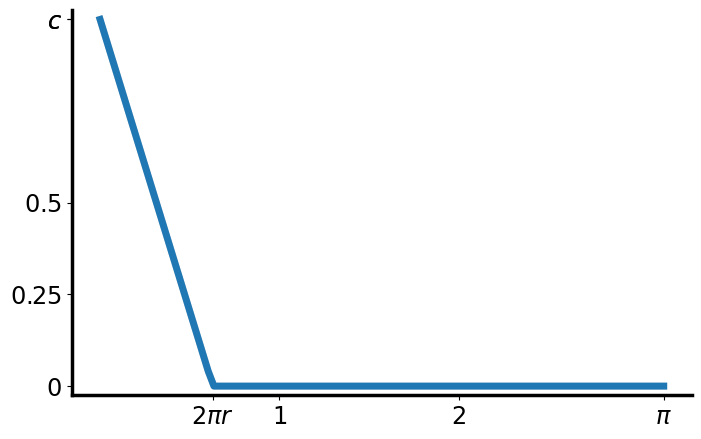

In [7]:
intfunc_fig = draw_interaction_function(builder)

### Network visualization

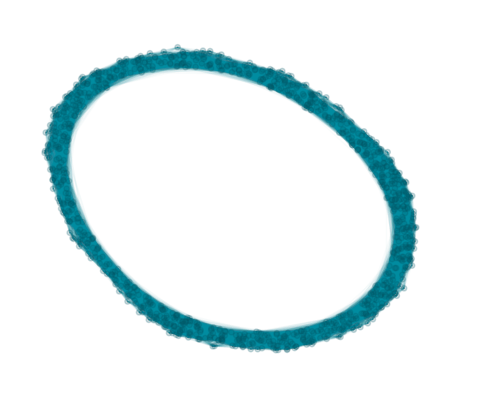

In [8]:
netviz_fig = draw_network_visualiztion(builder, N = 2**10, layout = 'spring')

### Clustering coefficient distribution

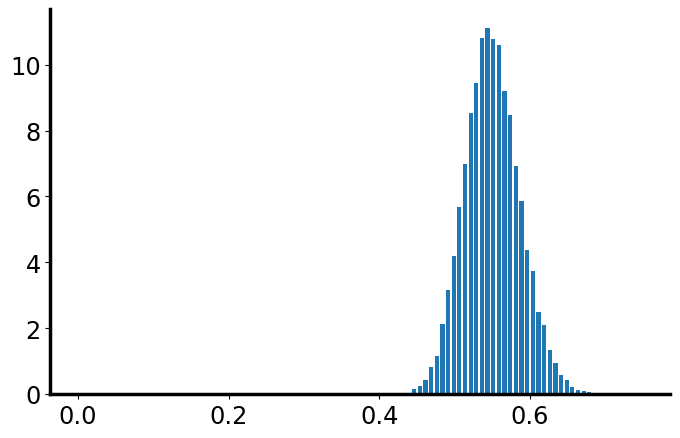

In [9]:
clustdist_fig = draw_clustering_distribution(builder, 
                                             with_labels = False, 
                                             n_ensemble = N_ENSEMBLE)

### Degree distribution

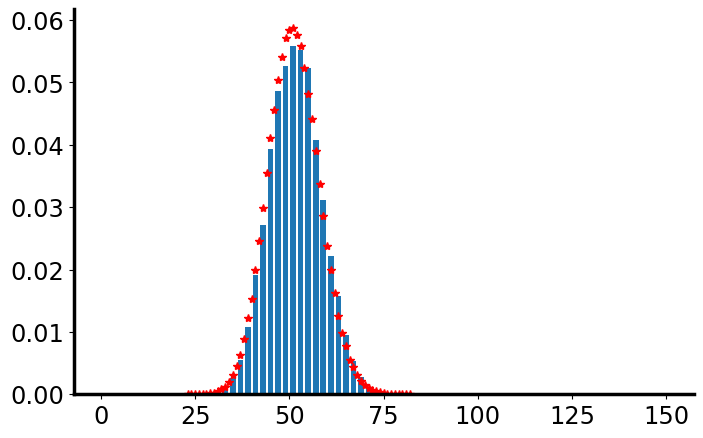

In [10]:
degdist_fig = draw_degree_distribution(builder, 
                                       n_ensemble = 2**5,
                                       with_labels = False)

### ring-score distribution

In [11]:
# n_ensemble = N_ENSEMBLE
# n_arg_points = 9

# arg_list = np.logspace(8, 10, n_arg_points, base=2, dtype=int)

# total = len(arg_list) * n_ensemble
# pbar = tqdm(product(arg_list, range(n_ensemble)), total = total)

# score = defaultdict(list)
# for arg, _ in pbar:
#     G = rng.network_model(N = arg, **CONFIGURATION[configuration])
#     try:
#         score[arg].append(rng.ring_score(G))
#     except rexceptions.DisconnectedGraphError:
#         continue

In [12]:
# chunks_score_df = [
#     pd.DataFrame(scores, columns=['score']).assign(N=arg) for arg, scores in score.items()
# ]

# score_df = pd.concat(chunks_score_df, ignore_index=True)
# plot_df = score_df.groupby('N').describe()['score']

In [13]:
# blues = sns.color_palette('Blues', n_arg_points)
# ringdist_fig, ax = plt.subplots(figsize = (12,8))

# sns.boxplot(score_df, x='N', y='score', ax = ax,  palette=blues)
# xticks = plt.xticks(np.linspace(0, n_arg_points-1, n_arg_points), arg_list)
# xlabel = ax.set_xlabel(r'Number of nodes ($N$) - log-scale')
# ylabel = ax.set_ylabel(r'ring score')

In [14]:
# intfunc_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-interactionFunction-{configuration}.png", transparent=True)
# intfunc_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-interactionFunction-{configuration}.pdf", transparent=True)

# netviz_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz-{configuration}.png", transparent=True)
# netviz_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz-{configuration}.pdf", transparent=True)

# clustdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-clusteringdist-{configuration}.png", transparent=True)
# clustdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-clusteringdist-{configuration}.pdf", transparent=True)

# degdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-degreedist-{configuration}.png", transparent=True)
# degdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-degreedist-{configuration}.pdf", transparent=True)

# ringdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-scoredist-{configuration}.png", transparent=True)
# ringdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-scoredist-{configuration}.pdf", transparent=True)

---

## Longer Response

In [15]:
configuration = 'longer_response'

G, pos, builder = rng.network_model(
                                N = N,
                                return_positions = True, 
                                return_builder = True,
                                **CONFIGURATION[configuration])

### Interaction function

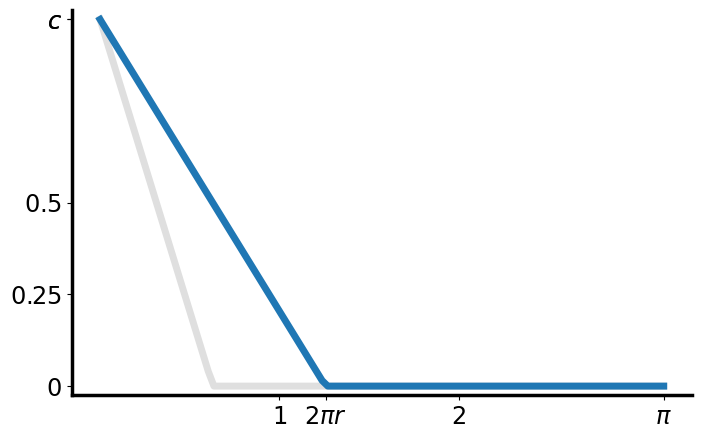

In [16]:
intfunc_fig = draw_interaction_function(builder)

### Network visualization

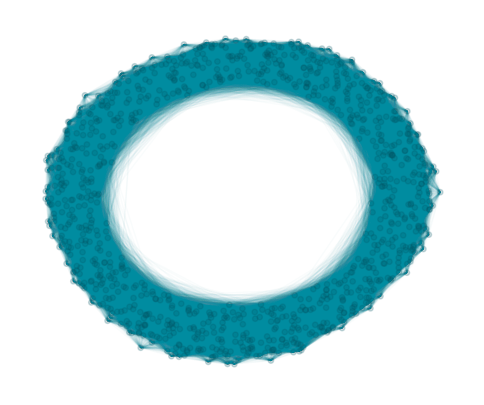

In [17]:
netviz_fig = draw_network_visualiztion(builder, N = 2**10, layout = 'spring')

### Clustering coefficient distribution

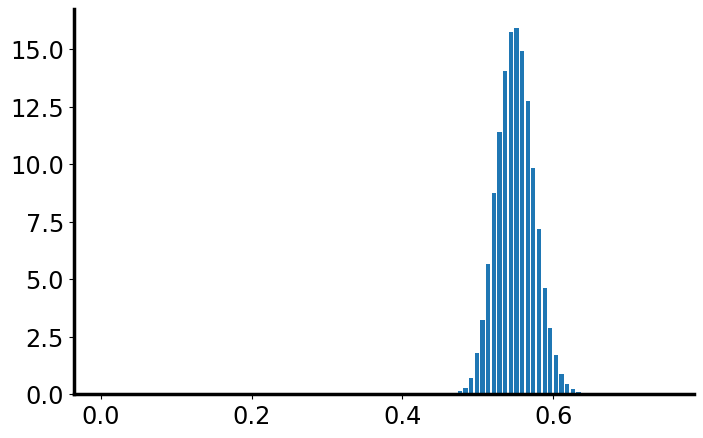

In [18]:
clustdist_fig = draw_clustering_distribution(builder, 
                                             with_labels = False, 
                                             n_ensemble = N_ENSEMBLE)

### Degree distribution

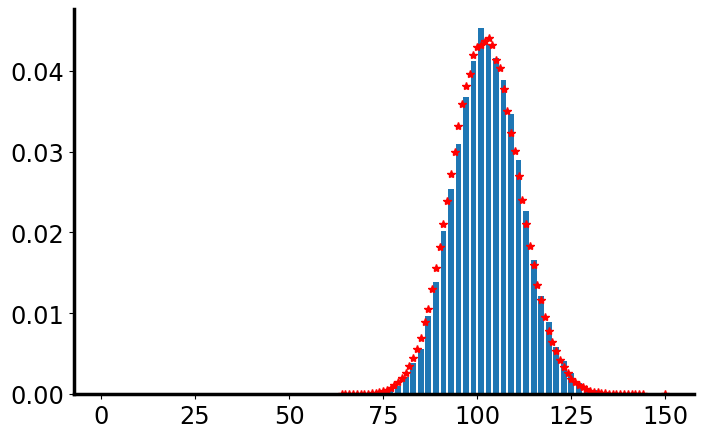

In [19]:
degdist_fig = draw_degree_distribution(builder, 
                                       n_ensemble = 2**6,
                                       with_labels = False)

### Ring-score distribution

100%|█████████████████████████████████████| 4096/4096 [3:04:14<00:00,  2.70s/it]


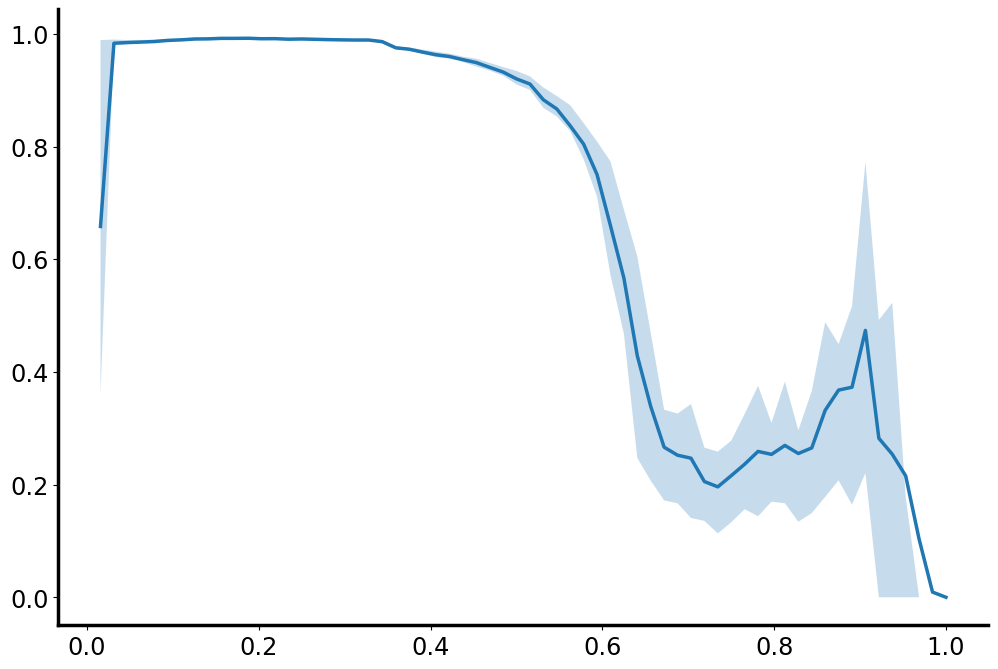

In [20]:
ringdist_fig = draw_ringscore_distribution(configuration, 
                                           n_ensemble = N_ENSEMBLE, 
                                           with_labels = False)

### Saving plots

In [21]:
intfunc_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-interactionFunction-{configuration}.png", transparent=True)
intfunc_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-interactionFunction-{configuration}.pdf", transparent=True)

netviz_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz-{configuration}.png", transparent=True)
netviz_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz-{configuration}.pdf", transparent=True)

clustdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-clusteringdist-{configuration}.png", transparent=True)
clustdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-clusteringdist-{configuration}.pdf", transparent=True)

degdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-degreedist-{configuration}.png", transparent=True)
degdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-degreedist-{configuration}.pdf", transparent=True)

ringdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-scoredist-{configuration}.png", transparent=True)
ringdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-scoredist-{configuration}.pdf", transparent=True)

---

## Stronger coupling

In [22]:
configuration = 'stronger_coupling'

G, pos, builder = rng.network_model(
                                N = N,
                                return_positions = True, 
                                return_builder = True,
                                **CONFIGURATION[configuration])

### Interaction function

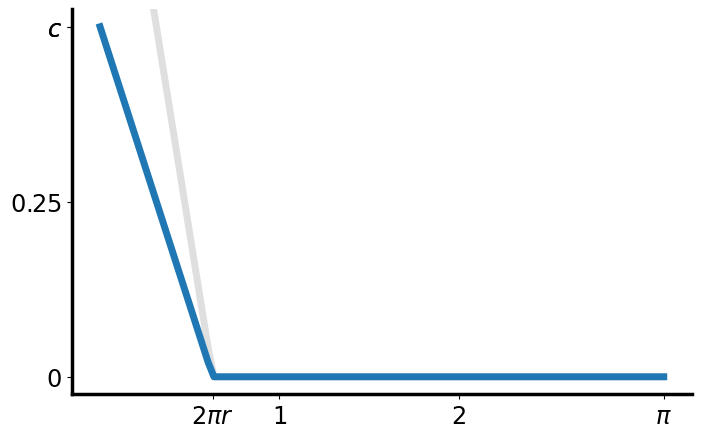

In [23]:
intfunc_fig = draw_interaction_function(builder)

### Network visualization

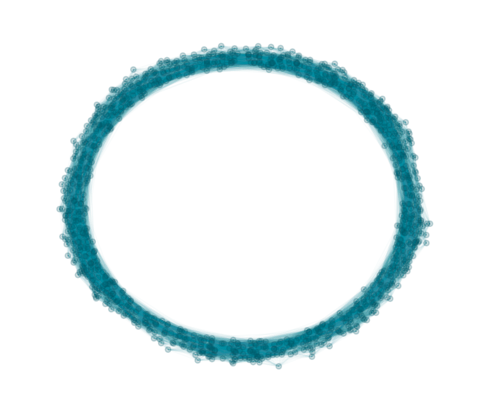

In [24]:
netviz_fig = draw_network_visualiztion(builder, N = 2**10, layout = 'spring')

### Clustering coefficient distribution

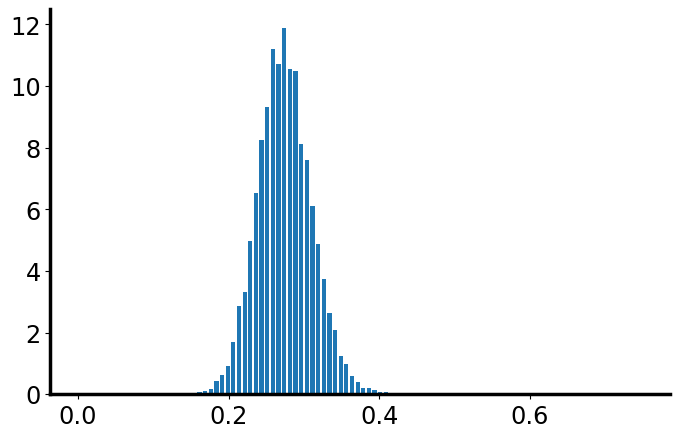

In [25]:
clustdist_fig = draw_clustering_distribution(builder, 
                                             with_labels = False, 
                                             n_ensemble = N_ENSEMBLE)

### Degree distribution

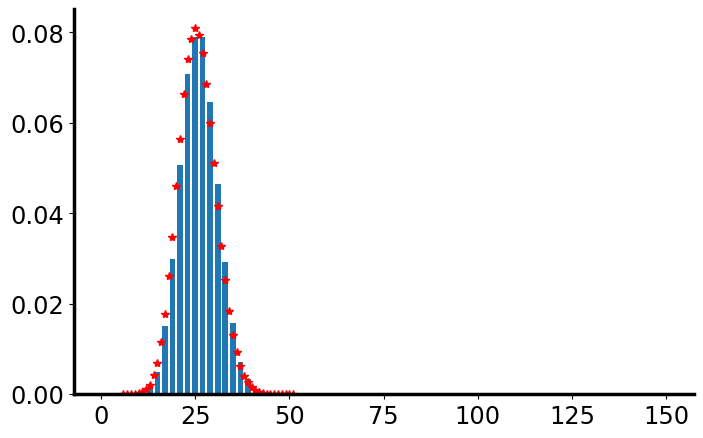

In [26]:
degdist_fig = draw_degree_distribution(builder, 
                                       n_ensemble = 2**6,
                                       with_labels = False)

### Ring-score distribution

100%|███████████████████████████████████████| 4096/4096 [58:38<00:00,  1.16it/s]


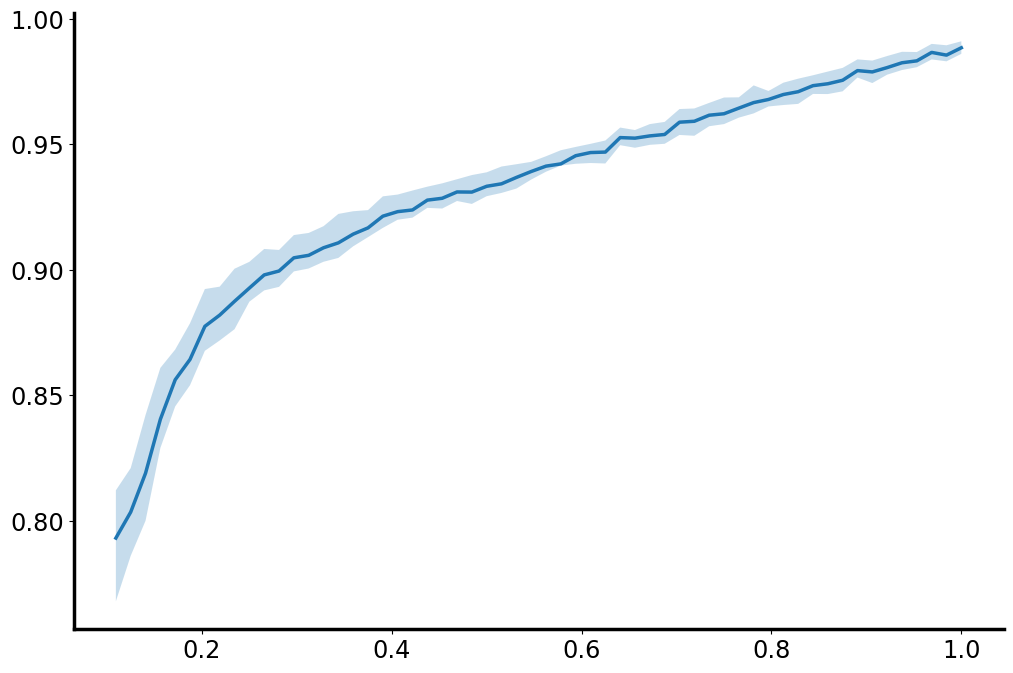

In [27]:
ringdist_fig = draw_ringscore_distribution(configuration, 
                                           n_ensemble = N_ENSEMBLE, 
                                           with_labels = False)

### Saving plots

In [28]:
intfunc_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-interactionFunction-{configuration}.png", transparent=True)
intfunc_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-interactionFunction-{configuration}.pdf", transparent=True)

netviz_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz-{configuration}.png", transparent=True)
netviz_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz-{configuration}.pdf", transparent=True)

clustdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-clusteringdist-{configuration}.png", transparent=True)
clustdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-clusteringdist-{configuration}.pdf", transparent=True)

degdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-degreedist-{configuration}.png", transparent=True)
degdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-degreedist-{configuration}.pdf", transparent=True)

ringdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-scoredist-{configuration}.png", transparent=True)
ringdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-scoredist-{configuration}.pdf", transparent=True)

## Shorter delay

In [6]:
configuration = 'shorter_delay'

G, pos, builder = rng.network_model(
                                N = N,
                                return_positions = True, 
                                return_builder = True,
                                **CONFIGURATION[configuration])

### Interaction function

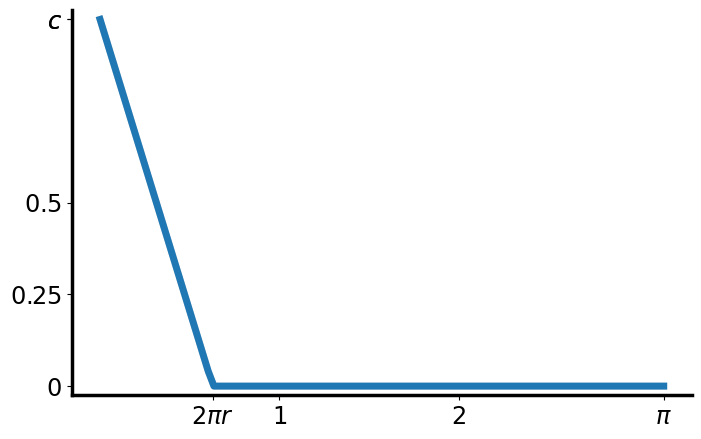

In [7]:
intfunc_fig = draw_interaction_function(builder)

### Network visualization

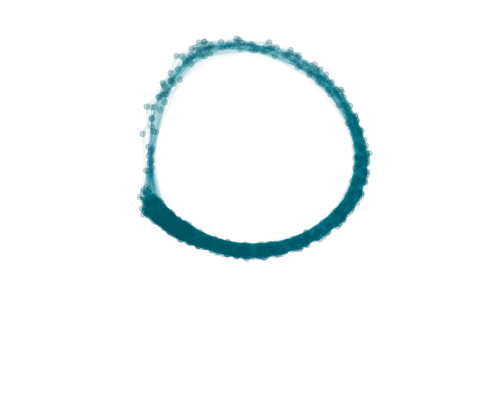

In [8]:
netviz_fig = draw_network_visualiztion(builder, N = 2**10, layout = 'spring')

### Clustering coefficient and degree distribution

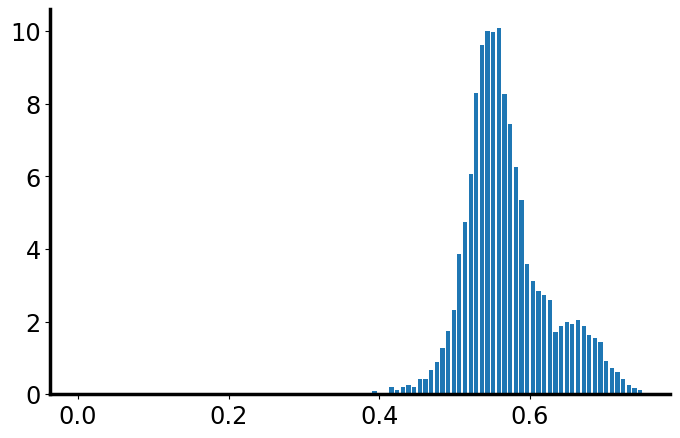

In [9]:
clustdist_fig = draw_clustering_distribution(builder, 
                                             with_labels = False, 
                                             n_ensemble = N_ENSEMBLE)

### Degree distribution

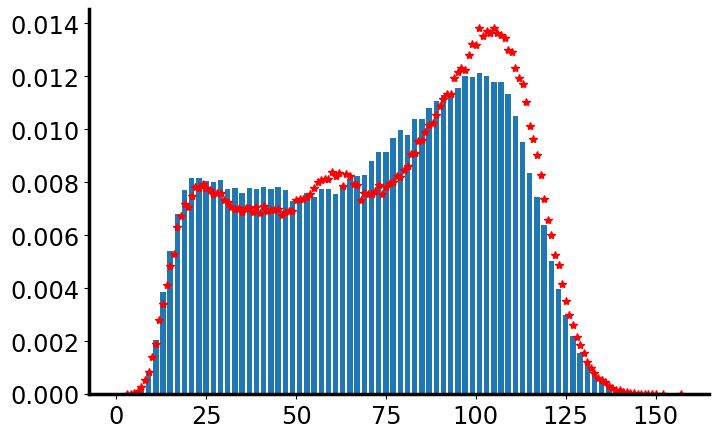

In [10]:
degdist_fig = draw_degree_distribution(builder, 
                                       n_ensemble = 2**9,
                                       with_labels = False)

### Ring-score distribution

100%|█████████████████████████████████████████| 256/256 [04:58<00:00,  1.16s/it]


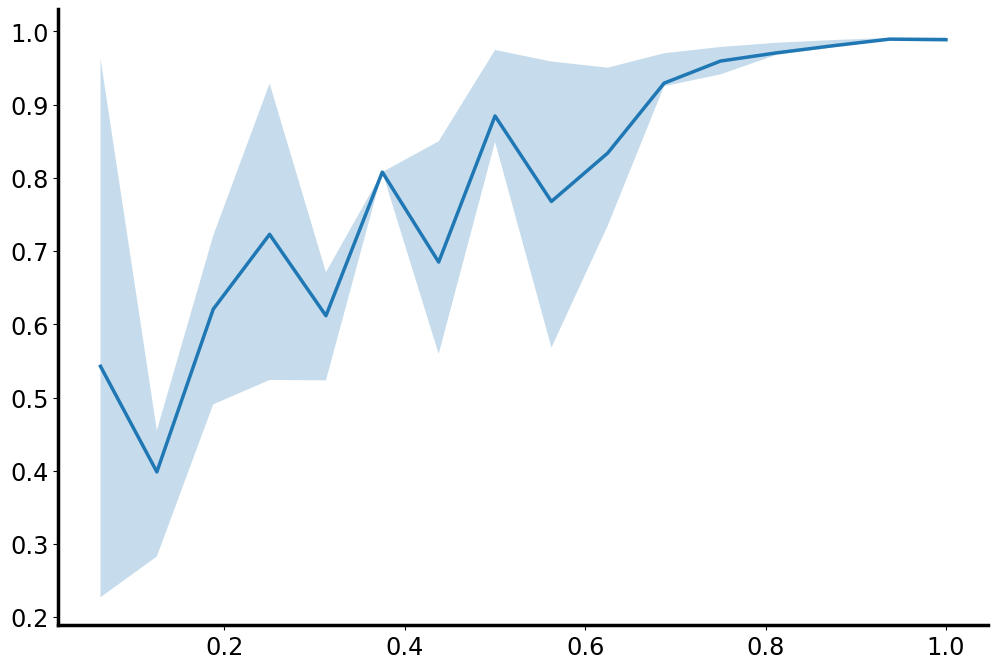

In [11]:
ringdist_fig = draw_ringscore_distribution(configuration, 
                                           n_ensemble = N_ENSEMBLE, 
                                           with_labels = False)

### Save plots

In [35]:
intfunc_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-interactionFunction-{configuration}.png", transparent=True)
intfunc_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-interactionFunction-{configuration}.pdf", transparent=True)

netviz_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz-{configuration}.png", transparent=True)
netviz_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz-{configuration}.pdf", transparent=True)

clustdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-clusteringdist-{configuration}.png", transparent=True)
clustdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-clusteringdist-{configuration}.pdf", transparent=True)

degdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-degreedist-{configuration}.png", transparent=True)
degdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-degreedist-{configuration}.pdf", transparent=True)

ringdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-scoredist-{configuration}.png", transparent=True)
ringdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-scoredist-{configuration}.pdf", transparent=True)

---

## Wrap up

In [36]:
t2 = time.time()

In [37]:
T = round(t2-t1)

print(f"Time to run the notebook: {timedelta(seconds=T)}")

Time to run the notebook: 5:30:48


Expected time: 4*45 = 3:00:00